# Hosting Detectron2 model on Sagemaker Inference endpoint

In this notebook we'll package previously trained model into PyTorch Serving container and deploy it on Sagemaker. First, let's review serving container. There are two key difference comparing to training container:
- we are using different base container provided by Sagemaker;
- we need to start Web server (refer to ENTRYPOINT command).

## Compiling Serving Container

In [ ]:
! pygmentize -l docker Dockerfile.serving

As in case of training image, we'll need to build and push container to AWS ECR. Before this, we'll need to loging to shared Sagemaker ECR and your local ECR

In [ ]:
# loging to Sagemaker ECR with Deep Learning Containers
!aws ecr get-login-password --region us-east-2 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-2.amazonaws.com
# loging to your private ECR
!aws ecr get-login-password --region us-east-2 | docker login --username AWS --password-stdin 553020858742.dkr.ecr.us-east-2.amazonaws.com

Now, let's build and push container using follow command. Note, that here we supply non-default Dockerfile.

In [ ]:
! ./build_and_push.sh d2-sm-coco-serving latest Dockerfile.serving

## Preparing test data

We'll be using coco2017 validation dataset. To simplify working with it, let's install locally Pycoco package

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
!pip install -U scikit-image

Now, let's download Coco2017 validation dataset

In [8]:
data_dir = "../datasets/coco/" # folder where data will be saved
dataset  = "val2017"

In [9]:
! mkdir -p {data_dir}{dataset}
! wget http://images.cocodataset.org/zips/val2017.zip -P {data_dir}
! unzip {data_dir}/val2017.zip -d {data_dir}

--2020-04-23 13:45:32--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.142.20
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.142.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘../datasets/coco/val2017.zip.1’

val2017.zip.1       100%[===================>] 777.80M  59.9MB/s    in 12s     

2020-04-23 13:45:44 (64.4 MB/s) - ‘../datasets/coco/val2017.zip.1’ saved [815585330/815585330]

Archive:  ../datasets/coco//val2017.zip
replace ../datasets/coco/val2017/000000212226.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [10]:
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {data_dir}
! unzip {data_dir}/annotations_trainval2017.zip -d {data_dir}{dataset}

--2020-04-23 13:46:16--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.28.124
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.28.124|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘../datasets/coco/annotations_trainval2017.zip.1’

annotations_trainva 100%[===================>] 241.19M  96.0MB/s    in 2.5s    

2020-04-23 13:46:19 (96.0 MB/s) - ‘../datasets/coco/annotations_trainval2017.zip.1’ saved [252907541/252907541]

Archive:  ../datasets/coco//annotations_trainval2017.zip
replace ../datasets/coco/val2017/annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Let's get a random image ...

In [11]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

annFile='{}{}/annotations/instances_{}.json'.format(data_dir,dataset, dataset)
coco=COCO(annFile)

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog']);
imgIds = coco.getImgIds(catIds=catIds);
imgId = imgIds[np.random.randint(len(imgIds))]
image_instance = coco.loadImgs(imgId)[0]
image_np = io.imread(image_instance['coco_url'])    

loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


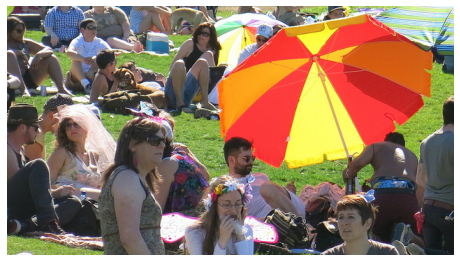

In [12]:
plt.axis('off')
plt.imshow(image_np)
plt.show()

# Testing inference script locally

Let's first check what inference script we'll deploy:

In [ ]:
!pip install sagemaker-inference

In [ ]:
!pygmentize container_serving/predict_coco.py

To test inference pipeline locally, you can run your `container_serving/predict_coco.py` locally (only code in __main__ guard will be executed). You'll need to have Detectron2 and number other packages locally installed to test it.

Make sure that you pass correct --model-dir argument.

In [ ]:
!python container_serving/predict_coco.py --image container_serving/coco_sample.jpg --model-dir ../trained_model

# Deploying Inference Endpoint

Below is some initial imports and configuration.

In [2]:
import boto3
import re

import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()

In [17]:
import sagemaker
from time import gmtime, strftime

sess = sagemaker.Session() # can use LocalSession() to run container locally

bucket = sess.default_bucket()
region = "us-east-2"
account = sess.boto_session.client('sts').get_caller_identity()['Account']
prefix_input = 'detectron2-input'
prefix_output = 'detectron2-ouput'

## Define parameters of your container

In [18]:
container_serving = "d2-sm-coco-serving" # your container name
tag = "latest" # you can have several version of container available
image = '{}.dkr.ecr.{}.amazonaws.com/{}:{}'.format(account, region, container_serving, tag)

print("Following container will be used for hosting: ",image)

Following container will be used for hosting:  553020858742.dkr.ecr.us-east-2.amazonaws.com/d2-sm-coco-serving:latest


## Deploy endpoint locally

As training on COCO2017 can be quite lenghty, we'll deploy our endpoint from model artifacts from already completed training jobs. Please review your training jobs, and find one which succesffuly completed. Then, copy model artifact S3 URI and.  pass it to `model_data` argument below.

In [19]:
from sagemaker.pytorch import PyTorchModel, PyTorch, PyTorchPredictor

model = PyTorchModel(
#                     model_data="s3://sagemaker-us-east-2-553020858742/detectron2-model/model.tar.gz", #default D2 model
                     model_data="s3://sagemaker-us-east-2-553020858742/detectron2-model/model_R_50_FPN_1x.tar.gz", # from training job
                     role=role,
                     entry_point="predict_coco.py", source_dir="container_serving",
                     framework_version="1.4", py_version="3.6",
                     image=image)

In [ ]:
predictor = model.deploy(
#                         instance_type='ml.p3.16xlarge', 
                         instance_type = 'local_gpu',
                         initial_instance_count=1,
                         endpoint_name=f"{container_serving}-{tag}", # define a unqie endpoint name; if ommited, Sagemaker will generate it based on used container
                         tags=[{"Key":"image", "Value":f"{container_serving}:{tag}"}], 
                         wait=True
                         )

In [ ]:
!curl -X POST 172.18.0.2:8080/invocations -v --data image_np # --header "Content-Type: application/x-npy"

## Deploy remote endpoint

To process inference data when we are sending it over internet, we need to have two customer ser/deser methods.

In [22]:
from sagemaker_inference import content_types, decoder, default_inference_handler, encoder
from sagemaker.content_types import CONTENT_TYPE_JSON, CONTENT_TYPE_CSV, CONTENT_TYPE_NPY

# These are serializer and deserializer to communication between client (e.g. this notebook) and Sagemaker endpoint.

def np_to_npy(request_body):
    encoder.encode(request_body, CONTENT_TYPE_NPY)

def bytes_to_pickle(response_body, content_type):
    try:
        return response_body.read()
    finally:
        response_body.close()
    
    

Gracefully stopping... (press Ctrl+C again to force)


In [23]:
from sagemaker.pytorch import PyTorchModel, PyTorch, PyTorchPredictor

print(image)

remote_model = PyTorchModel(
                     model_data="s3://sagemaker-us-east-2-553020858742/detectron2-model/model_R_50_FPN_1x.tar.gz",
                     role=role,
                     entry_point="predict_coco.py", source_dir="container_serving",
                     framework_version="1.4", py_version="3.6",
                     image=image)

553020858742.dkr.ecr.us-east-2.amazonaws.com/d2-sm-coco-serving:latest


In [ ]:
remote_predictor = remote_model.deploy(
                         instance_type='ml.p3.16xlarge', 
                         initial_instance_count=1,
                         endpoint_name=f"{container_serving}-{tag}", # define a unqie endpoint name; if ommited, Sagemaker will generate it based on used container
                         tags=[{"Key":"image", "Value":f"{container_serving}:{tag}"}], 
                         wait=True
                         )

In [ ]:
remote_predictor.predict(image_np)

In [ ]:
from sagemaker import RealTimePredictor



remote_rt_predictor  = RealTimePredictor(endpoint=f"d2-sm-coco-serving-latest",
                                sagemaker_session=sess,
                                serializer=np_to_npy,
                                deserializer=bytes_to_pickle
                               )


remote_rt_predictor.predict(image_np)

In [ ]:
predictor.delete_endpoint()